**Mohammad Zhalechian**
HW4, Oct 21

In [2]:
#-----------------------------------------------------------------------------
#--------------------------------Library--------------------------------------
#-----------------------------------------------------------------------------
import numpy as np
import time
import scipy as sp
import scipy.stats as st
import pandas as pd
from IPython.core.display import display, HTML
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Question 0 - Topics in Pandas

## Missing Values in Pandas

* Panda is flexible with regard to handling missing data
* $NaN$ is the default missing value marker in Pandas
* Pandas provides two function $insa()$ and $notna()$ to detect missing values

In [3]:
df = pd.DataFrame({'one': [1,2,3], 'two':['a','b','c']})
df2 = df.reindex([0,1,2,3,4])

pd.isna(df2)
pd.notna(df2)
pd.isna(df2['two'])

0    False
1    False
2    False
3     True
4     True
Name: two, dtype: bool

## Inserting Missing Values 

* We can insert missin values using $None$ or $numpy.nan$.
* Pandas objects provide compatibility between $None$ and $numpy.nan$.

In [39]:
df2.loc[0,'one'] = np.nan 
df2.loc[1,'two'] = None

pd.isna(df2)

,one,two
0,True,False
1,False,True
2,False,False
3,True,True
4,True,True


## Calculations with Missing Values

* Most of descriptive statistics and computational methods are written to account for missing data
* For example:
    * When summing data (e.g., $np.sum()$), missing values will be treated as zero.
    * Cumulative methods like $cumsum()$, $np.mean()$, $cumprod()$ ingnore the missing values be default. We can use $skipna=False$ to override this behavior.

In [40]:
np.sum(df2['one'])
np.mean(df2['one'])

2.5

## Filling missing values

* We can fill missing values using several methods
    * Replace missing values with a scalar value using $df.fillna('name')$.
    * Filling the missing values with non-missing values forward or backward using $df.fillna(method = 'pad')$. 

In [41]:
df3= df2.copy()
df3.fillna('missing')

df4= df2.copy()
df4.fillna(method = 'pad')

,one,two
0,NaN,a
1,2.0,a
2,3.0,c
3,3.0,c
4,3.0,c


### Question 1 - NHANES Table 1

In [4]:
#----------------------------- Part a ----------------------------------------
# Read data from local directory

demo_ghij = pd.read_pickle('demo_ghij.pkl')
ohxden_ghij = pd.read_pickle('ohxden_ghij.pkl')

#----------------------------- Part b ----------------------------------------

demo_ghij = pd.merge(demo_ghij, ohxden_ghij.loc[:, ['id','ohx_status']], 
                   on='id', how='outer')

# create a binary column indicating age <20 or not
demo_ghij['under_20'] = demo_ghij['age']
demo_ghij['under_20'][demo_ghij['under_20']< 20] = 1 
demo_ghij['under_20'][demo_ghij['under_20']!= 1] = 0

index_college = np.where(demo_ghij['education']
== ('some college or aa degree' or 'college graduate or above'))[0]
index_college_under20 = index_college[np.where(demo_ghij
                                    .loc[index_college,'under_20'] == 0)[0]]

demo_ghij['college'] = 0
demo_ghij['college'][index_college_under20] = 1
demo_ghij['college'] = pd.Categorical(demo_ghij['college']
.replace({1:'some college/college graduate', 0:'No college/<20'}))


df = demo_ghij[['id', 'gender', 'age', 'under_20', 
                'college', 'exam_status', 'ohx_status']]

df['ohx']=np.nan

df['ohx'][np.where((df['exam_status'] == 'both interviewed and mec examined') 
& (df['ohx_status'] == 'complete'))[0]] = 1

df['ohx'][np.where((df['ohx_status'] == 'not done') 
| (df['ohx_status'] == 'partial') | (pd.isna(df['ohx_status'])))[0]] = 0

df['ohx'] = pd.Categorical(df['ohx'].replace({1: 'complete', 0: 'missing'}))

#----------------------------- Part c ----------------------------------------

len(np.where(df['exam_status'] != 'both interviewed and mec examined')[0]) #1757

df = df.drop(np.where(df['exam_status'] 
!= 'both interviewed and mec examined')[0]) #37399



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launch

The number of subjects removed is $1757$, and the number of remainings are $37399$.

In [11]:
count_inf = pd.DataFrame({'gender': 
      df.groupby('ohx')['gender'].value_counts().unstack()['female'], 
      'under_20': df.groupby('ohx')['under_20'].value_counts().unstack()[1], 
      'college': df.groupby('ohx')['college'].value_counts()
      .unstack()['No college/<20']})
      
count_inf_2 = pd.DataFrame({'gender': 
      df.groupby('ohx')['gender'].value_counts().unstack()['male'], 
      'under_20': df.groupby('ohx')['under_20'].value_counts().unstack()[0], 
      'college': df.groupby('ohx')['college'].value_counts()
      .unstack()['some college/college graduate']})

pct_inf = (count_inf/(count_inf+count_inf_2)*100).round(2)

mean_inf = (df.groupby('ohx')[['age']].mean()).round(2)
std_inf = (df.groupby('ohx')[['age']].std()).round(2)

p_age = sp.stats.ttest_ind_from_stats(
      mean_inf.loc[0,'age'], std_inf.loc[0,'age'], 
      df.groupby('ohx')['age'].count()[0], 
      mean_inf.loc[1,'age'], std_inf.loc[1,'age'], 
      df.groupby('ohx')['age'].count()[1])[1]

p_gender = sp.stats.chi2_contingency(df.groupby('ohx')['gender']
    .value_counts().unstack())[1]
p_college = sp.stats.chi2_contingency(df.groupby('ohx')['college']
    .value_counts().unstack())[1]
p_under = sp.stats.chi2_contingency(df.groupby('ohx')['under_20']
    .value_counts().unstack())[1]

col_complete = [ (mean_inf['age'][0], std_inf['age'][0]), 
        (count_inf['under_20'][0], pct_inf['under_20'][0]), 
        (count_inf['gender'][0], pct_inf['gender'][0]),
        (count_inf['college'][0], pct_inf['college'][0])  ]

col_missing = [ (mean_inf['age'][1], std_inf['age'][1]), 
        (count_inf['under_20'][1], pct_inf['under_20'][1]), 
        (count_inf['gender'][1], pct_inf['gender'][1]),
        (count_inf['college'][1], pct_inf['college'][1])  ]

col_pvalue = [p_age, p_under, p_gender, p_college]

df_table = pd.DataFrame({'complete': col_complete, 'missing': col_missing, 
                         'p-value':col_pvalue })

df_table = df_table.set_index(pd.Index(['age','under_20','gender', 'college']))

#create table
cap = """
<b> Table 1.</b> <em> Summary Table.</em>
This table shows mean (std) for variable "age", and count and percentage for 
other variables. For "gender", "under_20" and "college", 
the table reports statistics corresponding to "female", "Yes", and 
"no college/<20" categories, repsectively.
"""
t1 = df_table.to_html(index=True)
t1 = t1.rsplit('\n')
t1.insert(1, cap)
tab1 = ''
for i, line in enumerate(t1):
    tab1 += line
    if i < (len(t1) - 1):
        tab1 += '\n'
        
display(HTML(tab1))

,complete,missing,p-value
age,"(33.17, 24.37)","(22.01, 26.59)",1.875573e-126
under_20,"(13991, 40.72)","(1762, 57.98)",4.959901e-76
gender,"(17342, 50.47)","(1626, 53.5)",1.439393e-03
college,"(28077, 81.71)","(2688, 88.45)",1.502345e-20


### Question 2 - Monte Carlo Comparison

Text(0.5,1,'Average relative width-Method 4')

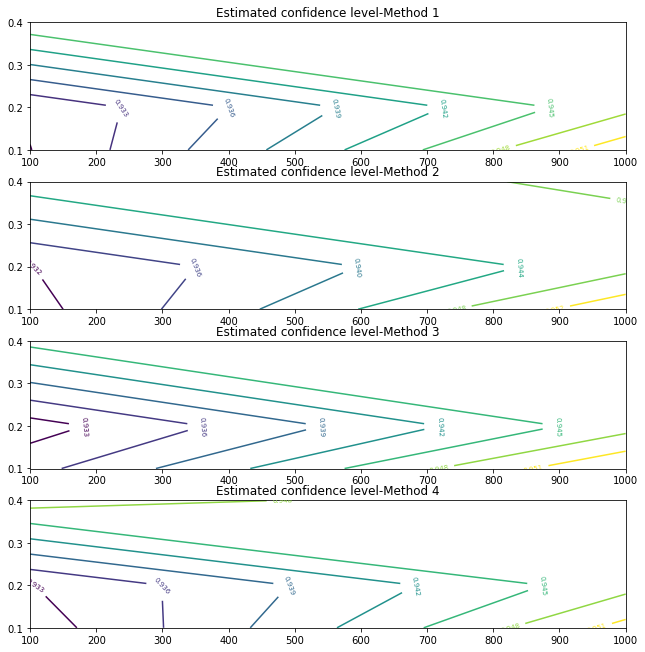

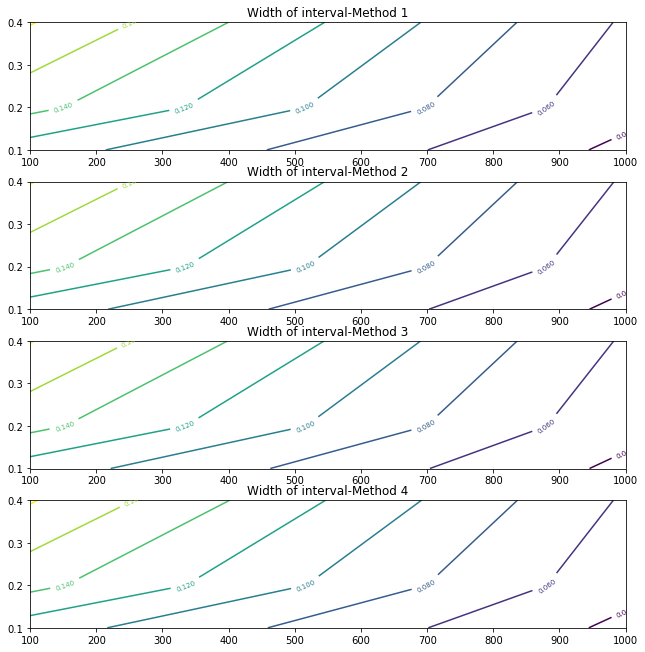

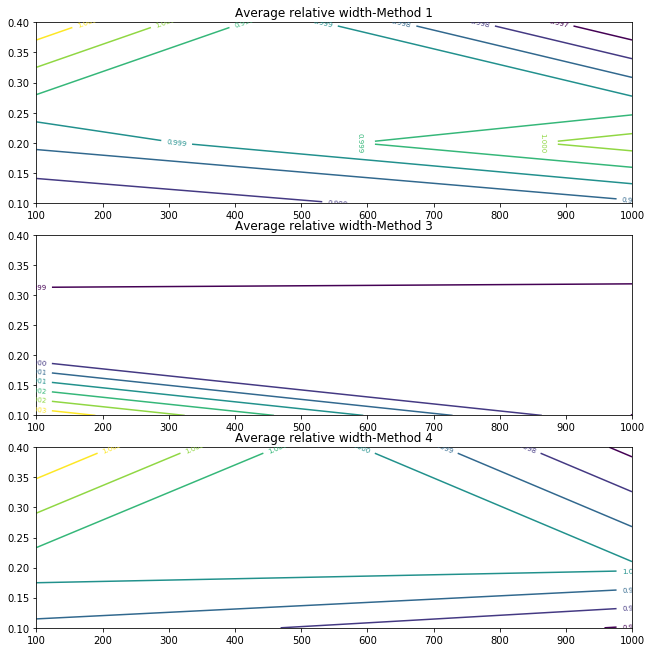

In [30]:
#----------------------------- Part a ----------------------------------------
# 95% nominal confidence interval 
alpha = 0.05

def ci(data, alpha, method):
    """
    Generates a confidence interval based on 4 methods for a population
    arising from a Binomial experiment 

    Parameters
    ----------
    data : ndarray
        An array comprising the binary trials.
    alpha : float
        confidence level.

    Returns
    -------
    string
        lower and upper bounds of confidence interval.
        
    """    
    n = len(data)
    phat= np.sum(data) / n
    x= np.sum(data)
    
    if method == 1 :
        lwr = phat - st.norm.ppf(1 - alpha / 2) * \
        np.sqrt(phat * (1 - phat) / n)
        upr = phat + st.norm.ppf(1 - alpha / 2) * \
        np.sqrt(phat * (1 - phat) / n)
  
    if method == 2 :
        lwr = st.beta.ppf(alpha / 2, x, n-x+1)
        upr = st.beta.ppf(1 - alpha / 2, x+1, n-x)

    if method == 3:
        lwr = max(0, st.beta.ppf(alpha/2, x + 0.5, n - x + 0.5))
        upr = min(1, st.beta.ppf(1 - alpha/2, x + 0.5, n - x + 0.5))

    if method == 4:
        ntilde = n + st.norm.ppf(1 - alpha / 2) ** 2
        ptilde = (x + st.norm.ppf(1 - alpha / 2) ** 2 / 2) / ntilde
        lwr = ptilde - st.norm.ppf(1 - alpha / 2) * \
        np.sqrt(ptilde * (1 - ptilde) / n)
        upr = ptilde + st.norm.ppf(1 - alpha / 2) * \
        np.sqrt(ptilde * (1 - ptilde) / n)
    

    return [lwr, upr]
       

# grids and number of monto-carlo replication
n_mc = []
for n in [100, 1000]:
      for p in [0.1, 0.2, 0.4]:
            n_mc.append(
                int(
            np.ceil(p * (1-p) * (200 * st.norm.ppf(1 - alpha / 2)) ** 2)))

#generate data based on (n,p)
df = pd.DataFrame({'1':[0 for i in range(6)], 
                        '2':[0 for i in range(6)], 
                        '3':[0 for i in range(6)], 
                        '4':[0 for i in range(6)]})
      
df_ci = pd.DataFrame({'1':[0 for i in range(6)], 
                        '2':[0 for i in range(6)], 
                        '3':[0 for i in range(6)], 
                        '4':[0 for i in range(6)]})
      

# monte-carlo study
k=0
for n in [100, 1000]:
      for p in [0.1, 0.2, 0.4]:
            for j in ['1','2','3','4']:
                  check = [0 for i in range(n_mc[k])]
                  width = [0 for i in range(n_mc[k])]
                  for h in range(n_mc[k]):
                        data = np.random.binomial(1, p, size=n)
                        output = ci(data, alpha, 1)
                        if p >= output[0] and p <= output[1]:
                              check[h] = 1 
                              width[h] = output[1] - output[0]
                  df.loc[k, j] = np.mean(check)
                  df_ci.loc[k, j] = np.mean(width)
            k += 1

#plot
#0: 100, 0.1
#1: 100, 0.2
#2: 100, 0.4
#3: 1000, 0.1
#4: 1000, 0.2
#5: 1000, 0.4

X , Y = np.meshgrid([100, 1000], [0.1, 0.2, 0.4])
Z_1 = np.array([   [df.loc[0,'1'], df.loc[3,'1']], 
                [df.loc[1,'1'], df.loc[4,'1']], 
                [df.loc[2,'1'], df.loc[5,'1']]     ])
Z_2 = np.array([   [df.loc[0,'2'], df.loc[3,'2']], 
                [df.loc[1,'2'], df.loc[4,'2']], 
                [df.loc[2,'2'], df.loc[5,'2']]     ])
Z_3 = np.array([   [df.loc[0,'3'], df.loc[3,'3']], 
                [df.loc[1,'3'], df.loc[4,'3']], 
                [df.loc[2,'3'], df.loc[5,'3']]     ])
Z_4 = np.array([   [df.loc[0,'4'], df.loc[3,'4']], 
                [df.loc[1,'4'], df.loc[4,'4']], 
                [df.loc[2,'4'], df.loc[5,'4']]     ])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9,9))
fig.tight_layout()
cs1 = axes[0].contour([100, 1000], [0.1, 0.2, 0.4], Z_1)
axes[0].clabel(cs1, inline=True, fontsize=7)
axes[0].set_title('Estimated confidence level-Method 1')

cs2 = axes[1].contour([100, 1000], [0.1, 0.2, 0.4], Z_2)
axes[1].clabel(cs2, inline=True, fontsize=7)
axes[1].set_title('Estimated confidence level-Method 2')

cs3 = axes[2].contour([100, 1000], [0.1, 0.2, 0.4], Z_3)
axes[2].clabel(cs3, inline=True, fontsize=7)
axes[2].set_title('Estimated confidence level-Method 3')

cs4 = axes[3].contour([100, 1000], [0.1, 0.2, 0.4], Z_4)
axes[3].clabel(cs4, inline=True, fontsize=7)
axes[3].set_title('Estimated confidence level-Method 4')


#----------------------------- Part b ----------------------------------------
#width of interval
Z_ci_1 = np.array([   [df_ci.loc[0,'1'], df_ci.loc[3,'1']], 
                [df_ci.loc[1,'1'], df_ci.loc[4,'1']], 
                [df_ci.loc[2,'1'], df_ci.loc[5,'1']]     ])
Z_ci_2 = np.array([   [df_ci.loc[0,'2'], df_ci.loc[3,'2']], 
                [df_ci.loc[1,'2'], df_ci.loc[4,'2']], 
                [df_ci.loc[2,'2'], df_ci.loc[5,'2']]     ])
Z_ci_3 = np.array([   [df_ci.loc[0,'3'], df_ci.loc[3,'3']], 
                [df_ci.loc[1,'3'], df_ci.loc[4,'3']], 
                [df_ci.loc[2,'3'], df_ci.loc[5,'3']]     ])
Z_ci_4 = np.array([   [df_ci.loc[0,'4'], df_ci.loc[3,'4']], 
                [df_ci.loc[1,'4'], df_ci.loc[4,'4']], 
                [df_ci.loc[2,'4'], df_ci.loc[5,'4']]     ])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9,9))
fig.tight_layout()
cs1 = axes[0].contour([100, 1000], [0.1, 0.2, 0.4], Z_ci_1)
axes[0].clabel(cs1, inline=True, fontsize=7)
axes[0].set_title('Width of interval-Method 1')

cs2 = axes[1].contour([100, 1000], [0.1, 0.2, 0.4], Z_ci_2)
axes[1].clabel(cs2, inline=True, fontsize=7)
axes[1].set_title('Width of interval-Method 2')

cs3 = axes[2].contour([100, 1000], [0.1, 0.2, 0.4], Z_ci_3)
axes[2].clabel(cs3, inline=True, fontsize=7)
axes[2].set_title('Width of interval-Method 3')

cs4 = axes[3].contour([100, 1000], [0.1, 0.2, 0.4], Z_ci_4)
axes[3].clabel(cs4, inline=True, fontsize=7)
axes[3].set_title('Width of interval-Method 4')


#average relative width
df_rw = df_ci.copy()
df_rw = df_rw.apply(lambda x: x/df_rw['2'])
df_rw = df_rw.drop(['2'], axis=1)


Z_rw_1 = np.array([   [df_rw.loc[0,'1'], df_rw.loc[3,'1']], 
                [df_rw.loc[1,'1'], df_rw.loc[4,'1']], 
                [df_rw.loc[2,'1'], df_rw.loc[5,'1']]     ])
Z_rw_3 = np.array([   [df_rw.loc[0,'3'], df_rw.loc[3,'3']], 
                [df_rw.loc[1,'3'], df_rw.loc[4,'3']], 
                [df_rw.loc[2,'3'], df_rw.loc[5,'3']]     ])
Z_rw_4 = np.array([   [df_rw.loc[0,'4'], df_rw.loc[3,'4']], 
                [df_rw.loc[1,'4'], df_rw.loc[4,'4']], 
                [df_rw.loc[2,'4'], df_rw.loc[5,'4']]     ])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,9))
fig.tight_layout()
cs1 = axes[0].contour([100, 1000], [0.1, 0.2, 0.4], Z_rw_1)
axes[0].clabel(cs1, inline=True, fontsize=7)
axes[0].set_title('Average relative width-Method 1')

cs3 = axes[1].contour([100, 1000], [0.1, 0.2, 0.4], Z_rw_3)
axes[1].clabel(cs3, inline=True, fontsize=7)
axes[1].set_title('Average relative width-Method 3')

cs4 = axes[2].contour([100, 1000], [0.1, 0.2, 0.4], Z_rw_4)
axes[2].clabel(cs4, inline=True, fontsize=7)
axes[2].set_title('Average relative width-Method 4')